![](https://images.unsplash.com/photo-1536303100418-985cb308bb38?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1500&q=80)

# Introduction

This notebook uses the House Price dataset to find and elimentate outliers (anomalies) elegantly **without** removing data.

Outlier detection means identifying something that could not be stated as “normal”. The definition of “normal” depends on the phenomenon that is being observed and the properties it bears. In this notebook, we dive deep into an unsupervised outlier detection algorithm called **IsolationForest** and use it on the House Price data set. This algorithm beautifully exploits the characteristics of outliers, keeping it independent of data distributions and making the approach novel.

The core of the algorithm is to “isolate” outliers by creating decision trees over random attributes. The random partitioning produces noticeable shorter paths for outliers since:

* fewer instances (of outliers) result in smaller partitions
* distinguishable attribute values are more likely to be separated in early partitioning

Hence, when a forest of random trees collectively produces shorter path lengths for some particular points, then they are highly likely to be outliers.

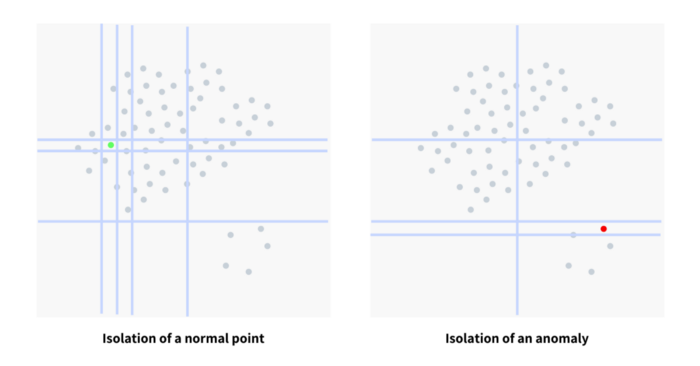

The diagram above shows the number of splits required to isolate a normal point and an outlier. Splits, represented through blue lines, happens at random on a random attribute and in the process building a decision tree. The number of splits determines the level at which the isolation happened and will be used to generate the outlier score.

The process is repeated multiple times and we note the isolation level for each point/instance. Once the iterations are over, we generate an outlier score for each point/instance, suggesting its likeliness to be an outlier. The score is a function of the average level at which the point was isolated. The top samples gathered on the basis of the score are labeled as outliers.

Sources:

https://medium.com/@often_weird/isolation-forest-algorithm-for-anomaly-detection-f88af2d5518d <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html <br>

We start by loading the data set and do a bit of pre-processing

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.reset_option('^display.', silent=True)

# Load the two datasets
X_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
X_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# Seperate independent and dependent variable
num_train = len(X_train)
num_test = len(X_test)
y_train = X_train.SalePrice
X_train.drop(['SalePrice'], axis=1, inplace=True)

# Merge train and test data to simplify processing
df = pd.concat([X_train, X_test], ignore_index=True)

# Rename odd-named columns
df = df.rename(columns={"1stFlrSF": "FirstFlrSF",
                        "2ndFlrSF": "SecondFlrSF",
                       "3SsnPorch": "ThirdSsnPorch"})

# Shopw 5 samples
df.head()

Next step is some fairly simple pre-processing before we are able to run IsolationForest. We drop columns with an excessive number of NaN's (>1000) and fill missing values for all features. In the end we confirm that there is no longer any missing values.

In [ ]:
# Find columns with more than 1000 NaN's and drop them (see above)
columns = [col for col in df.columns if df[col].isnull().sum() > 1000]
df = df.drop(columns, axis=1)

# Fill LotFrontage with median
df['LotFrontage'].fillna((df['LotFrontage'].mean()), inplace=True)

# No garage values means no year, area or cars
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)
    
# No garage info means you don't have one
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('None')

# Fill no basement
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].fillna('None')

# Fill remaining categorical and numerical cols with None and 0
cat_columns = df.select_dtypes('object').columns
num_columns = [i for i in list(df.columns) if i not in cat_columns]
df.update(df[cat_columns].fillna('None'))
df.update(df[num_columns].fillna(0))

# Check for missing values 
print(df.isnull().values.any())

# Isolation Forest

The Isolation Forest (IF) algorithm works best when the trees are not created from the entire data set, but from a sub-sampled data set. This is very different from almost all other techniques where they thrive on data and demands more of it for greater accuracy. Sub-sampling works wonder in this algorithm because normal instances can interfere with the isolation process by being a little closer to the outliers. In this example we set max_samples=100, so that Isolation Forest draws 100 samples to train the base estimator for each feature. <br>

Explanation:

* **clf.fit** fits the base estimator using the max_samples count for the particular feature. <br>
* **clf.predict** returns -1 if observation is deemed an outlier, otherwise 1 <br>
* **clf.decision_function** returns the measured outlier score based on fitted model <br>

The stats dataframe simply holds the original sample values, their scores, if IF thinks they're an outlier or not and some simple statistics for the feature like min, max and median values.

In [ ]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(0)

# Helper function to train and predict IF model for a feature
def train_and_predict_if(df, feature):
    clf = IsolationForest(max_samples=100, random_state=rng)
    clf.fit(df[[feature]])
    pred = clf.predict(df[[feature]])
    scores = clf.decision_function(df[[feature]])
    stats = pd.DataFrame()
    stats['val'] = df[feature]
    stats['score'] = scores
    stats['outlier'] = pred 
    stats['min'] = df[feature].min()
    stats['max'] = df[feature].max()
    stats['mean'] = df[feature].mean()
    stats['feature'] = [feature] * len(df)
    return stats

# Helper function to print outliers
def print_outliers(df, feature, n):
    print(feature)
    print(df[feature].head(n).to_string(), "\n")

# Run through all features and save the outlier scores for each feature
num_columns = [i for i in list(df.columns) if i not in list(df.select_dtypes('object').columns) and i not in ['Id']]
result = pd.DataFrame()
for feature in num_columns:
    stats = train_and_predict_if(df, feature)
    result = pd.concat([result, stats])
    
# Gather top outliers for each feature
outliers = {team:grp.drop('feature', axis=1) 
       for team, grp in result.sort_values(by='score').groupby('feature')}

# Print the top 10 outlier samples for a few selected features
n_outliers = 10
print_outliers(outliers, "LotArea", n_outliers)
print_outliers(outliers, "YearBuilt", n_outliers)
print_outliers(outliers, "BsmtUnfSF", n_outliers)
print_outliers(outliers, "GarageYrBlt", n_outliers)

Let's quickly review the results for these features:

* LotArea has 4 significant outliers (-1) with an outlier score of about -0.33 and values above the 100000. These are far away from the mean value of 10168 for that feature. We see that LotArea goes between 1300 and 215245, so reducing the impact that these four observations (out of a total of has on the variance of this feature could benefit our modelling process later on. <br>
* YearBuilt is not as diverse as LotArea, as the maximum outlier score is found to be about -0.25. The shows that values at not that far from the mean. For this feature, IF found that the lowest values (~1880) were outliers. <br>
* BsmtUnfSF mimics YearBuilt, but has significant higher variance. <br>
* GarageYrBlt obviously has outliers at 0 val according to IF, but these make sense, as these observations are those without any garage at all. There is a majority of houses with a GarageYrBlt and they deviate a lot from the mean.

Next we use the pandas' clipping feature to trim outlier values at input thresholds. It works by assigning a minimum ands maximum value of that particular feature. All observations with a value lower that the min will be assigned the min, and all observations with a value higher than the max will be assigned the max. These are just example values, tweak as you like.

In [ ]:
# Use clipping to level out the observed outliers in the data
df.LotArea = df.LotArea.clip(1300,50000)
df.YearBuilt = df.YearBuilt.clip(1880,2010)
df.BsmtUnfSF = df.BsmtUnfSF.clip(100,1900)
df.GarageYrBlt = df.GarageYrBlt.clip(0,2020)

Now we re-train the IsolationForest classifier to see if clipping the values has improved the outlier scores. Notice how the outlier scores produced by IsolationForest for the example features has now gone down after we clipped them.

In [ ]:
# Train IsolationForest again, this time after with clipped outliers for 4 features
result = pd.DataFrame()
for feature in num_columns:
    stats = train_and_predict_if(df, feature)
    result = pd.concat([result, stats])

# Gather top outliers for each feature
outliers = {team:grp.drop('feature', axis=1) 
       for team, grp in result.sort_values(by='score').groupby('feature')}


# Print the top 10 outlier samples for the features we chose to clip
n_outliers = 10
print_outliers(outliers, "LotArea", n_outliers)
print_outliers(outliers, "YearBuilt", n_outliers)
print_outliers(outliers, "BsmtUnfSF", n_outliers)
print_outliers(outliers, "GarageYrBlt", n_outliers)

# Conclusion

This nootebok demonstrated how Isolation Forest can be used to track outliers in a data set. We used the house price data set as an example. Isolation Forest thrives on sub-sampled data and does not need to build the tree from the entire data set. It works well with sub-sampled data. The algorithm executes really fast, since it does not depend on computationally expensive operations like distance or density calculation. The training stage has a linear time complexity with a low constant and hence could be used for any larger data processing scenario.